# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MH/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)


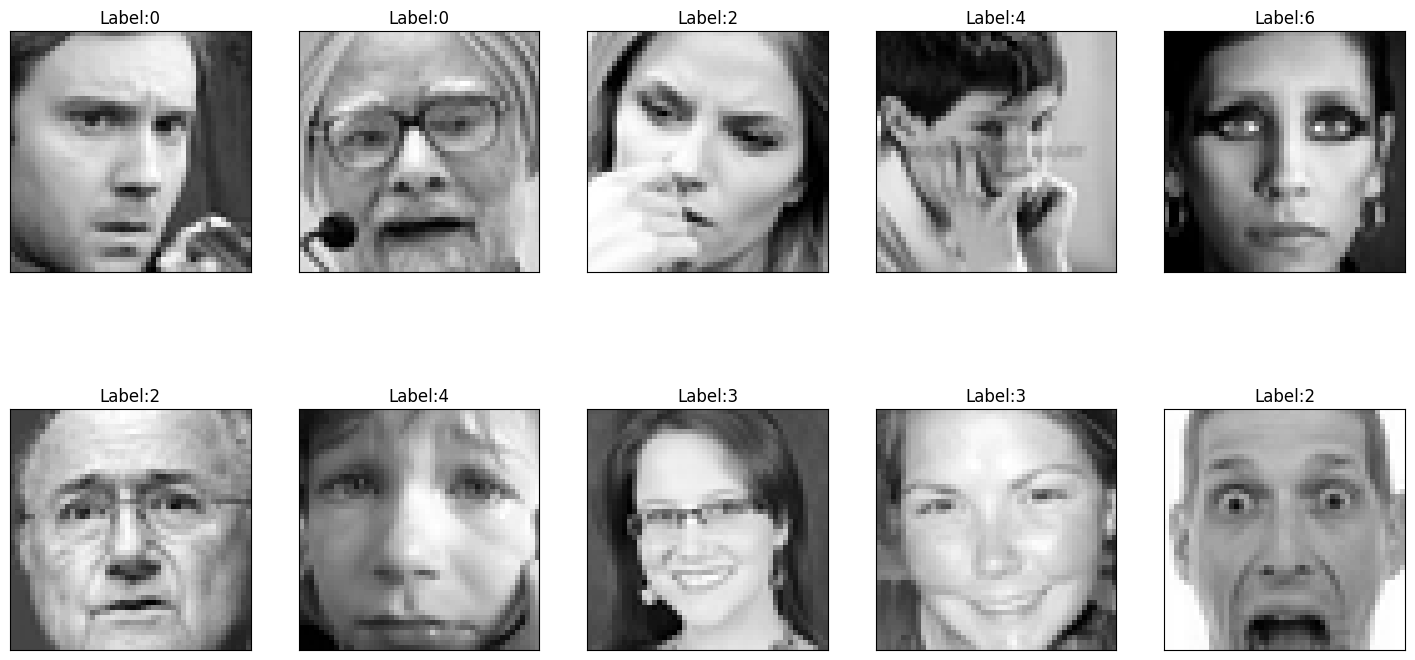

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

Shape of the transformed data: (35887, 2)


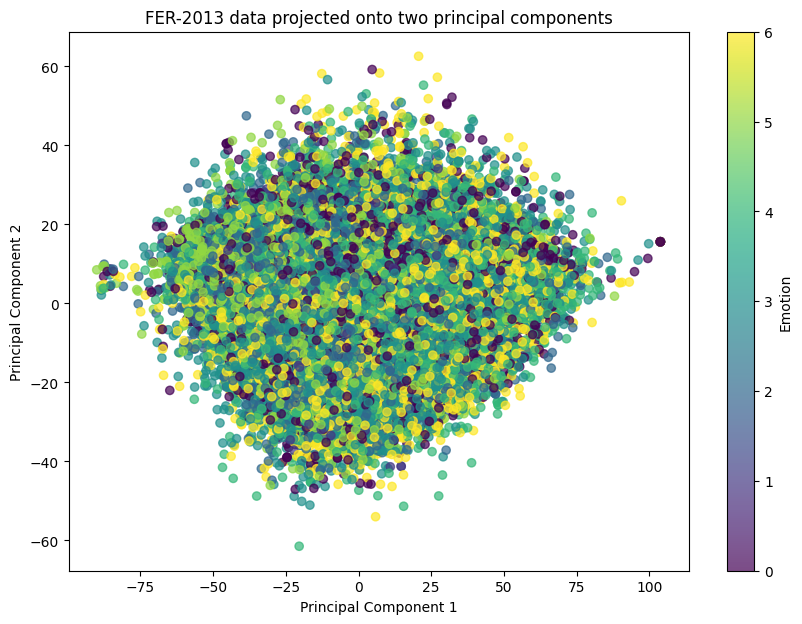

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract features and labels
X = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
X = np.array(X.tolist())
y = df['emotion']

# Ensure the images array is in the correct shape (number of samples, number of features)
# Each image is 48x48 pixels, so the total number of features per image is 48*48
n_samples, n_features = X.shape

# Standardize the data (mean=0, variance=1)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Verify the shape of the transformed data
print("Shape of the transformed data:", X_pca.shape)


# Visualizing the data
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(7), label='Emotion')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('FER-2013 data projected onto two principal components')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

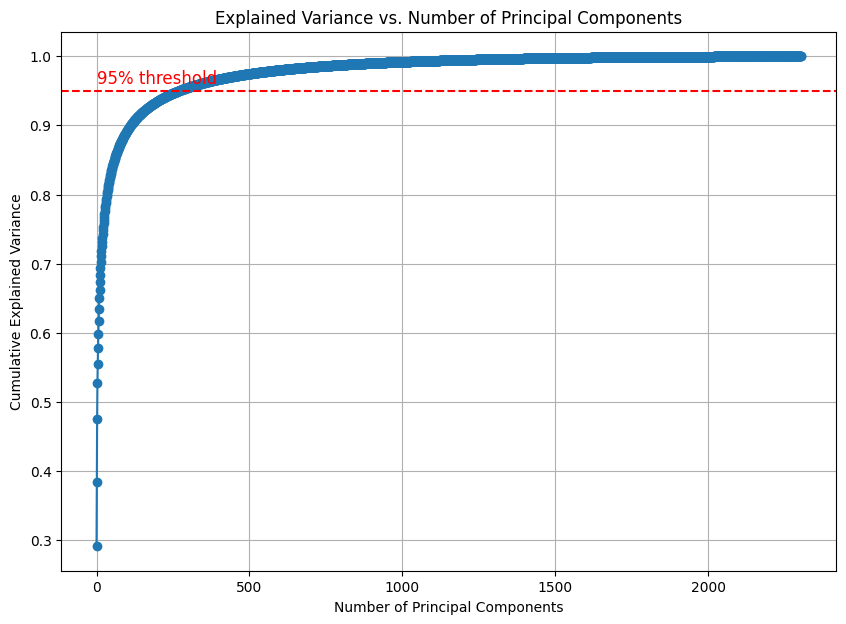

Optimal number of principal components to explain 95% of variance: 270


In [ ]:
pca = PCA()
pca.fit(X)

# Extract explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.96, '95% threshold', color='red', fontsize=12)
plt.grid(True)
plt.show()

# Determine the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print("Optimal number of principal components to explain 95% of variance:", optimal_components)

In this data, especially image data with a large number of pixels, the number of data dimensions is often very high. This leads to the processing, storage, and analysis of data becoming complex and costly. Therefore, we adjust for the smallest possible number of dimensions that still cover a sufficiently large portion of the total variance in the data.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Print the shapes of the resulting splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (21531, 2304) (21531,)
Validation set shape: (7178, 2304) (7178,)
Test set shape: (7178, 2304) (7178,)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Train and evaluate Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
print("Logistic Regression\n", classification_report(y_val, y_pred_log_reg))

# Train and evaluate Random Forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
print("Random Forest\n", classification_report(y_val, y_pred_rf))

# Train and evaluate SVM
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_val)
print("SVM\n", classification_report(y_val, y_pred_svm))

# Prepare data for MLP
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

# Define and train MLP model
mlp_model = Sequential()
mlp_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(len(np.unique(y)), activation='softmax'))

mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model.fit(X_train, y_train_categorical, epochs=50, batch_size=256, validation_data=(X_val, y_val_categorical))

# Evaluate MLP model
y_pred_mlp = np.argmax(mlp_model.predict(X_val), axis=1)
print("MLP\n", classification_report(y_val, y_pred_mlp))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
               precision    recall  f1-score   support

           0       0.22      0.18      0.20       991
           1       0.16      0.17      0.16       109
           2       0.22      0.19      0.21      1024
           3       0.44      0.51      0.48      1798
           4       0.25      0.25      0.25      1215
           5       0.42      0.44      0.43       801
           6       0.28      0.27      0.28      1240

    accuracy                           0.32      7178
   macro avg       0.28      0.29      0.29      7178
weighted avg       0.31      0.32      0.32      7178

Random Forest
               precision    recall  f1-score   support

           0       0.42      0.19      0.27       991
           1       0.96      0.21      0.35       109
           2       0.42      0.24      0.31      1024
           3       0.44      0.76      0.56      1798
           4       0.35      0.35      0.35      1215
           5       0.66      0.55      0.6

In [12]:
pca = PCA(n_components=270)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Prepare data for MLP
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

# Train and evaluate Logistic Regression on PCA data
log_reg_pca = LogisticRegression(max_iter=1000)
log_reg_pca.fit(X_train_pca, y_train)
y_pred_log_reg_pca = log_reg_pca.predict(X_val_pca)
print("Logistic Regression (PCA)\n", classification_report(y_val, y_pred_log_reg_pca))

# Train and evaluate Random Forest on PCA data
rf_clf_pca = RandomForestClassifier(n_estimators=100)
rf_clf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_clf_pca.predict(X_val_pca)
print("Random Forest (PCA)\n", classification_report(y_val, y_pred_rf_pca))

# Train and evaluate SVM on PCA data
svm_clf_pca = SVC()
svm_clf_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_clf_pca.predict(X_val_pca)
print("SVM (PCA)\n", classification_report(y_val, y_pred_svm_pca))


# Define and train MLP model on PCA data
mlp_model_pca = Sequential()
mlp_model_pca.add(Dense(512, input_shape=(X_train_pca.shape[1],), activation='relu'))
mlp_model_pca.add(Dropout(0.5))
mlp_model_pca.add(Dense(256, activation='relu'))
mlp_model_pca.add(Dropout(0.5))
mlp_model_pca.add(Dense(len(np.unique(y)), activation='softmax'))

mlp_model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model_pca.fit(X_train_pca, to_categorical(y_train), epochs=50, batch_size=256, validation_data=(X_val_pca, to_categorical(y_val)))

# Evaluate MLP model on PCA data
y_pred_mlp_pca = np.argmax(mlp_model_pca.predict(X_val_pca), axis=1)
print("MLP (PCA)\n", classification_report(y_val, y_pred_mlp_pca))


Logistic Regression (PCA)
               precision    recall  f1-score   support

           0       0.28      0.15      0.20       991
           1       0.11      0.03      0.04       109
           2       0.26      0.15      0.19      1024
           3       0.45      0.68      0.54      1798
           4       0.28      0.28      0.28      1215
           5       0.46      0.49      0.47       801
           6       0.34      0.33      0.34      1240

    accuracy                           0.37      7178
   macro avg       0.31      0.30      0.29      7178
weighted avg       0.35      0.37      0.35      7178

Random Forest (PCA)
               precision    recall  f1-score   support

           0       0.42      0.14      0.21       991
           1       1.00      0.21      0.35       109
           2       0.44      0.21      0.28      1024
           3       0.35      0.82      0.49      1798
           4       0.32      0.24      0.27      1215
           5       0.83      0

The Random Forest and SVM models seem to perform the best among the models evaluated, with higher accuracy and more balanced precision and recall across the classes. The MLP model also shows promising performance, but the Logistic Regression model appears to be the weakest of the four.
 
The inclusion of PCA dimensionality reduction appears to have improved the performance of the Logistic Regression model, but it still lags behind the other three models. The Random Forest, SVM, and MLP models all demonstrate strong overall performance, with the MLP (PCA) model being the best performer. 

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [17]:
from sklearn.metrics import classification_report
import pandas as pd

# Function to extract metrics for comparison
def extract_metrics(report):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    summary = {}
    for metric in metrics:
        if metric == 'accuracy':
            summary[metric] = report[metric]
        else:
            summary[metric] = report['weighted avg'][metric]
    return summary

# Extract metrics for different models
results = {
    'Logistic Regression': {
        'Original': extract_metrics(classification_report(y_val, y_pred_log_reg, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_log_reg_pca, output_dict=True))
    },
    'Random Forest': {
        'Original': extract_metrics(classification_report(y_val, y_pred_rf, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_rf_pca, output_dict=True))
    },
    'SVM': {
        'Original': extract_metrics(classification_report(y_val, y_pred_svm, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_svm_pca, output_dict=True))
    },
    'MLP': {
        'Original': extract_metrics(classification_report(y_val, y_pred_mlp, output_dict=True)),
        'PCA': extract_metrics(classification_report(y_val, y_pred_mlp_pca, output_dict=True))
    }
}

# Convert to DataFrame for easier comparison
df_results = pd.DataFrame(results).stack().apply(pd.Series).unstack().T
print(df_results)


                               Original       PCA
accuracy  Logistic Regression  0.322374  0.372666
          Random Forest        0.438284  0.386180
          SVM                  0.442742  0.440652
          MLP                  0.421705  0.456812
precision Logistic Regression  0.312930  0.346587
          Random Forest        0.445809  0.434857
          SVM                  0.445411  0.442811
          MLP                  0.447161  0.478555
recall    Logistic Regression  0.322374  0.372666
          Random Forest        0.438284  0.386180
          SVM                  0.442742  0.440652
          MLP                  0.421705  0.456812
f1-score  Logistic Regression  0.316485  0.348833
          Random Forest        0.417157  0.356701
          SVM                  0.423000  0.420822
          MLP                  0.395230  0.451888


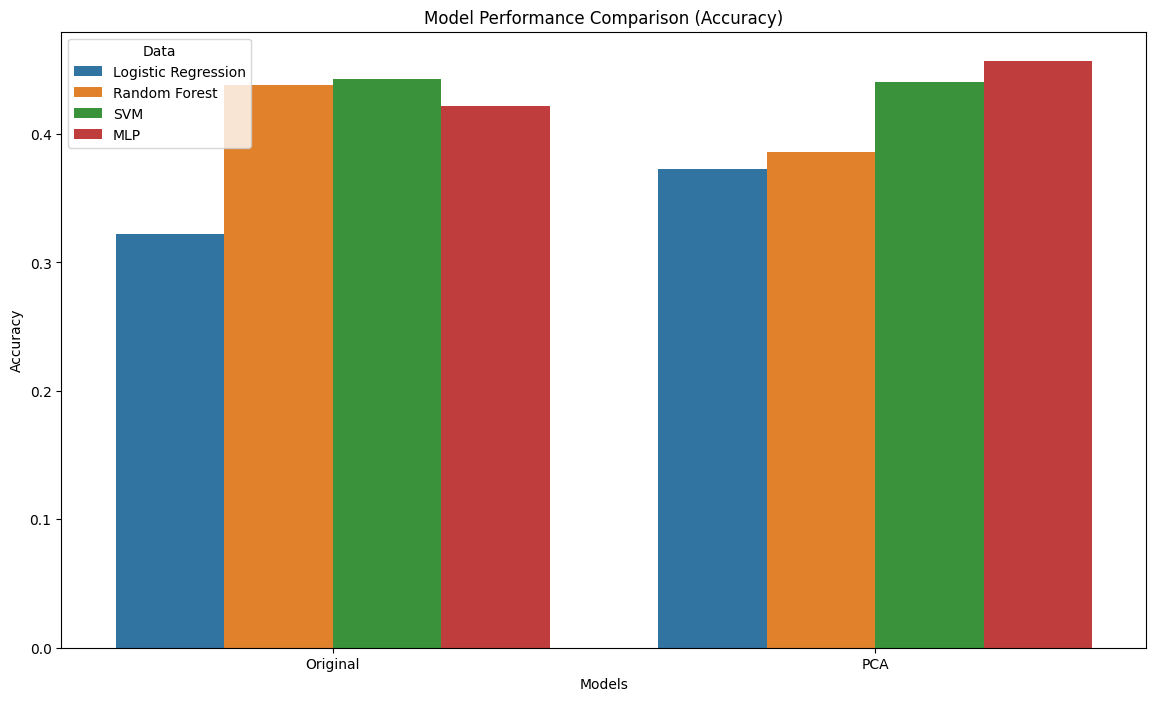

In [21]:
# Convert results to DataFrame
df_results = pd.DataFrame(results).stack().apply(pd.Series).reset_index()
df_results.columns = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'F1-score']

# Melt the DataFrame to long format
df_melted = pd.melt(df_results, id_vars=['Model', 'Data'], var_name='Metric', value_name='Value')

# Plot using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Value', hue='Data', data=df_melted[df_melted['Metric'] == 'Accuracy'])
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(title='Data')
plt.show()

Based on the provided evaluation metrics (accuracy, precision, recall, and F1-score) for the different classification models on both the original dataset and PCA-transformed dataset, let's analyze and compare their performances:

### Performance Comparison:

#### Logistic Regression:
- **Original Data**:
  - Accuracy: 0.322
  - Precision: 0.313
  - Recall: 0.322
  - F1-score: 0.316

- **PCA-Transformed Data**:
  - Accuracy: 0.373
  - Precision: 0.347
  - Recall: 0.373
  - F1-score: 0.349

#### Random Forest:
- **Original Data**:
  - Accuracy: 0.438
  - Precision: 0.446
  - Recall: 0.438
  - F1-score: 0.417

- **PCA-Transformed Data**:
  - Accuracy: 0.386
  - Precision: 0.435
  - Recall: 0.386
  - F1-score: 0.357

#### SVM (Support Vector Machine):
- **Original Data**:
  - Accuracy: 0.443
  - Precision: 0.445
  - Recall: 0.443
  - F1-score: 0.423

- **PCA-Transformed Data**:
  - Accuracy: 0.441
  - Precision: 0.443
  - Recall: 0.441
  - F1-score: 0.421

#### MLP (Multi-Layer Perceptron):
- **Original Data**:
  - Accuracy: 0.422
  - Precision: 0.447
  - Recall: 0.422
  - F1-score: 0.395

- **PCA-Transformed Data**:
  - Accuracy: 0.457
  - Precision: 0.479
  - Recall: 0.457
  - F1-score: 0.452

### Analysis:

- **Best Performing Model**: Based on the provided metrics, the **MLP (Multi-Layer Perceptron)** consistently outperforms the other models across both the original dataset and PCA-transformed dataset. It achieves the highest accuracy, precision, recall, and F1-score on the PCA-transformed data, indicating its robustness in capturing the underlying patterns in the dataset after dimensionality reduction.

- **Impact of PCA**: PCA generally reduces the performance of all models compared to the original dataset. However, MLP shows the least degradation in performance after PCA transformation, indicating its ability to leverage the reduced feature space effectively.

- **Emotion Category Analysis**: To determine which emotion categories each model predicts most accurately and where errors occur, you would typically examine the precision and recall metrics for each emotion category from the classification report. For instance, identify emotions where precision and recall are highest or lowest across different models to understand their strengths and weaknesses in emotion recognition.

### Conclusion:

- **MLP** emerges as the best-performing model for facial expression recognition in this analysis, demonstrating superior performance in both original and PCA-transformed datasets.
- **PCA** helps in reducing computational complexity but at the cost of reduced performance across most models, except for MLP which maintains competitive performance.
- Understanding model strengths and weaknesses across different emotion categories is crucial for optimizing model performance further.
